In [99]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

In [100]:
trajs = pd.read_csv('../hrrr17x_0.csv')
# only keep columns callsign, groundspeed, timestamp, latitude, longitude, altitude, track, vertical_rate
trajs = trajs[['callsign', 'groundspeed', 'timestamp', 'latitude', 'longitude', 'altitude', 'track', 'vertical_rate']]
trajs.head()

,callsign,groundspeed,timestamp,latitude,longitude,altitude,track,vertical_rate
0,ABX3122,494.0,2017-01-01 10:00:01+00:00,35.557577,-104.181830,40975.0,98.261289,-64.0
1,GTI3403,511.0,2017-01-01 10:00:01+00:00,32.571996,-99.635682,36900.0,81.552473,0.0
2,AAL8,530.0,2017-01-01 10:00:01+00:00,34.226074,-109.079665,37000.0,85.236358,0.0
3,SKW5364,504.0,2017-01-01 10:00:01+00:00,32.345993,-101.605408,35000.0,80.631176,0.0
4,AAL6,504.0,2017-01-01 10:00:01+00:00,34.304123,-107.654189,36975.0,85.906288,0.0


In [101]:
callsigns = trajs['callsign'].unique()
print('There are {} unique callsigns'.format(len(callsigns)))

There are 31 unique callsigns


# Step 1: Drop callsigns that are in the TMA at the beginning

In [102]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
# Add search path 
import sys
sys.path.append('../wx')

In [104]:
from roi import KDFW, ROI_RADIUS, WX_ROI # KDFW coordinates

Haversine formula to calculate distance between two points on a sphere

In [105]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert coordinates from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance # in kilometers


In [106]:
# Calculate distance for each row
trajs['distance'] = haversine(trajs['latitude'], trajs['longitude'], KDFW[1], KDFW[0]) # KDFW[1] is latitude, KDFW[0] is longitude

In [107]:
# Compute the max distance for each callsign
max_distance_per_callsign = trajs.groupby('callsign')['distance'].max()

# Callsigns that are within the radius
callsigns_to_drop = max_distance_per_callsign[max_distance_per_callsign < ROI_RADIUS].index
print('There are {} callsigns within the radius to be dropped'.format(len(callsigns_to_drop)))

# Drop callsigns that are within the radius
trajs = trajs[~trajs['callsign'].isin(callsigns_to_drop)]

There are 0 callsigns within the radius to be dropped


# Drop callsigns that haven't landed

In [108]:
# Compute the max distance for each callsign
min_distance_per_callsign = trajs.groupby('callsign')['distance'].min()

# Callsigns that are within the radius
callsigns_to_drop_2 = min_distance_per_callsign[min_distance_per_callsign > 30].index # 4km within the airport is considered as at the airport
print('There are {} callsigns that haven\'t landed and was dropped'.format(len(callsigns_to_drop_2)))

# Drop callsigns that are within the radius
trajs = trajs[~trajs['callsign'].isin(callsigns_to_drop_2)]

There are 18 callsigns that haven't landed and was dropped


# Plotting of a sample trajectory

In [117]:
from viz import plot_traj_from_df, plot_setup
from cartopy import crs as ccrs

NameError: name 'WX_ROI' is not defined

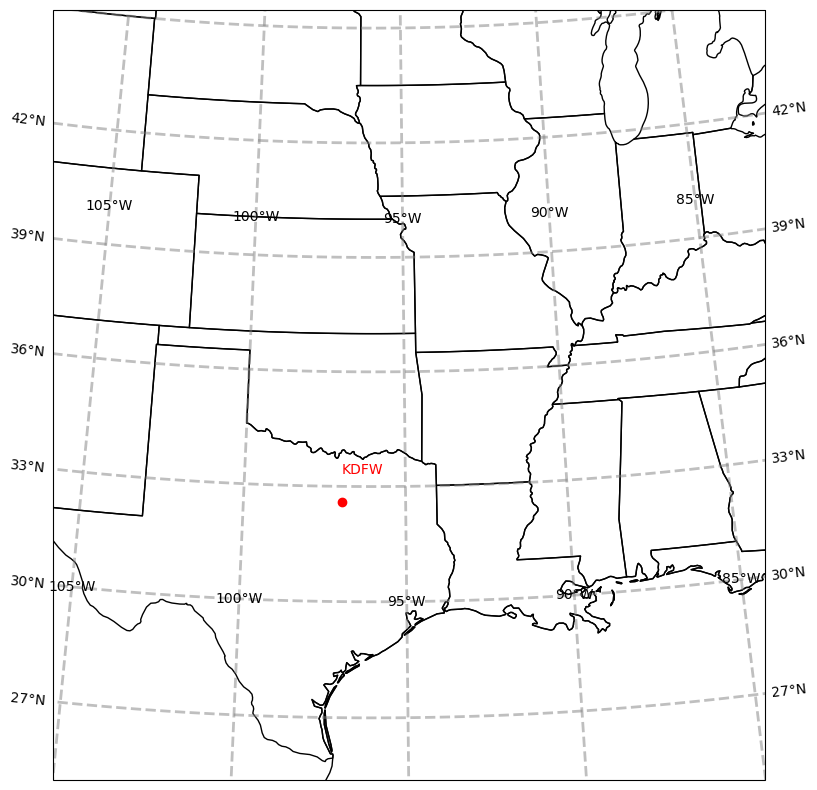

In [119]:
fig, ax = plot_setup()

# Draw two lines, one for each meridian and parallel that we want to highlight.
ax.plot([WX_ROI[0][0], WX_ROI[0][0]], [WX_ROI[1][0], WX_ROI[1][1]], color='red', transform=ccrs.PlateCarree(), linewidth=2)
ax.plot([WX_ROI[0][0], WX_ROI[0][1]], [WX_ROI[1][0], WX_ROI[1][0]], color='yellow', transform=ccrs.PlateCarree(), linewidth=2)

for csg in trajs['callsign'].unique():
    plot_traj_from_df(trajs, csg, ax)